In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from feature import MatchSIFT, EstimateE_RANSAC, convert_to_homo, convert_to_inhomo

## Data preparation
1. Defining the camera intrinsic parameters
2. Image Loading

In [3]:
f = 1209.60
w_im = 1008
h_im = 756

K = np.asarray([
    [f, 0, w_im / 2.],
    [0, f, h_im / 2.],
    [0, 0, 1]
])
num_images = 2

# Load input images
Im = np.empty((num_images, h_im, w_im, 3), dtype=np.uint8)
for i in range(2):
    im_file = 'im2/image{:07d}.jpg'.format(i+1)
    im = cv2.imread(im_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    Im[i,:,:,:] = im

Plot sample images

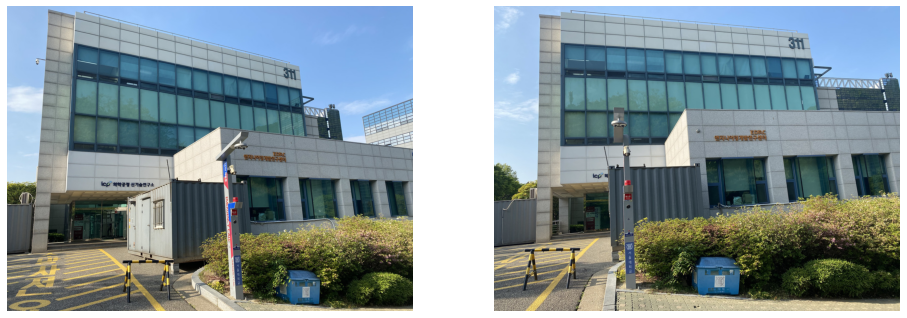

In [4]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(Im[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Im[1])
plt.axis('off')

plt.savefig('two pics.pdf')
plt.show()

## Feature extraction

In [5]:
# SIFT 
sift = cv2.xfeatures2d.SIFT_create()
des = []
kp = []
loc = []
for i in range(num_images):
    k, d = sift.detectAndCompute(Im[i], None)
    des.append(d)
    kp.append(k)
    loc.append(np.array([_k.pt for _k in k]))

## Match Features
Here, I used the cv2.BFMatch since it is more convinient for visualization.

(e.g. cv2.drawMatchesKnn takes the Match object defined in the opencv)

In [6]:
#x0, x1, ind0 = MatchSIFT(loc[0], des[0], loc[1], des[1])

In [7]:
# use Matcher provided by opencv for visualization.
bf = cv2.BFMatcher()
matches = bf.knnMatch(des[0],des[1],k=2)

good = []
for m,n in matches:
    # for better vis, changed the ratio test hyperparameter from 0.75 to 0.5
    if m.distance < 0.5*n.distance: 
        good.append([m])

Visualize SIFT feature matching examples

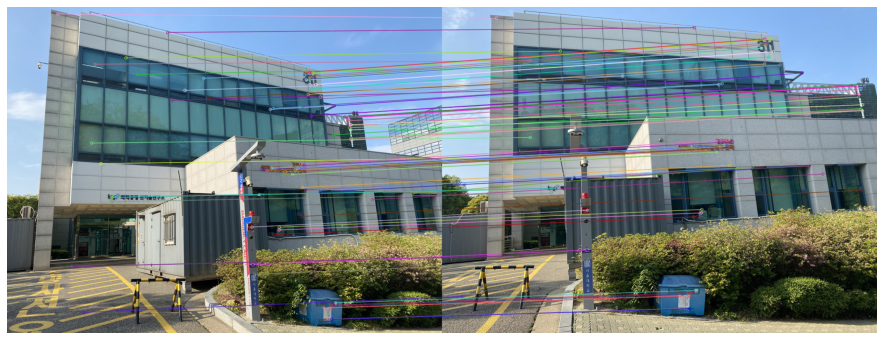

In [8]:
vis = cv2.drawMatchesKnn(Im[0],kp[0], Im[1],kp[1],
                         good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 6))
plt.imshow(vis)
plt.axis('off')

plt.savefig('sift.pdf')
plt.show()

## Find Essential(Fundamental) Matrix
Although we can directly find the fundamental matrix using 8 points, I converted the essential matrix to the fundamental matrix to reuse my funcs.

In [9]:
# reuse my func
x0, x1, ind0 = MatchSIFT(loc[0], des[0], loc[1], des[1])

In [10]:
ransac_n_iter = 200
ransac_thr = 1e-2

In [11]:
inv_K = np.linalg.inv(K)

In [12]:
# find the essential matrix
x0 = convert_to_inhomo((inv_K @ convert_to_homo(x0).T).T)
x1 = convert_to_inhomo((inv_K @ convert_to_homo(x1).T).T)

E, inlier = EstimateE_RANSAC(x0, x1, ransac_n_iter, ransac_thr)

In [13]:
# convert to the fundamental matrix
F = inv_K.T @ E @ inv_K

u, s, vh = np.linalg.svd(F)
s[-1] = 0
F = u @ np.diag(s) @ vh

In [14]:
# project rays
x0 = convert_to_inhomo((K @ convert_to_homo(x0).T).T)
x1 = convert_to_inhomo((K @ convert_to_homo(x1).T).T)

In [15]:
# This draws lines and circles
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),10,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),10,color,-1)
    return img1,img2

Plot epipolar lines

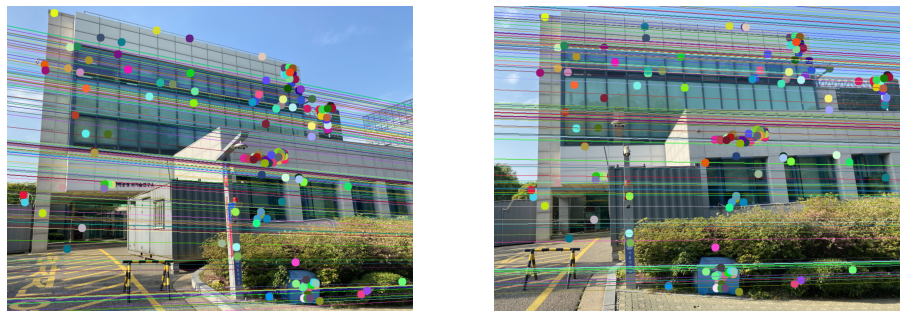

In [16]:
lines1 = cv2.computeCorrespondEpilines(x1.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(Im[0], Im[1], lines1, x0.astype(int), x1.astype(int))

lines2 = cv2.computeCorrespondEpilines(x0.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3,img4 = drawlines(Im[1], Im[0], lines2, x1.astype(int), x0.astype(int))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img5)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img3)
plt.axis('off')

plt.savefig('epipole.pdf')
plt.show()